In [64]:
import os
sys.path.append(r'C:\Users\Hp\Desktop\ml labs\timeseires')

In [65]:
import sys
sys.path.append(r'C:\Users\Hp\Desktop\ml labs\timeseires')

from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [67]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [68]:
def CNN():
    input_data = Input(shape=(time_steps, num_features))
    x1 = Conv1D(16, 2, activation="relu")(input_data)
    x2 = Conv1D(16, 2, activation="relu")(x1)
    flatten = Flatten()(x2)
    output_data = Dense(1)(flatten)
    model = Model(input_data, output_data)
    return model

In [69]:
model1 = CNN()
model1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 24, 21)]          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 23, 16)            688       
                                                                 
 conv1d_13 (Conv1D)          (None, 22, 16)            528       
                                                                 
 flatten_6 (Flatten)         (None, 352)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 353       
                                                                 
Total params: 1,569
Trainable params: 1,569
Non-trainable params: 0
_________________________________________________________________


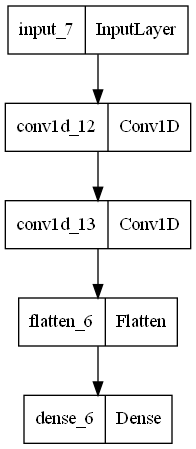

In [70]:
tensorflow.keras.utils.plot_model(model1 )

In [72]:
checkpoints = r'C:\Users\Hp\Desktop\ml labs\last labs\lab 8\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'C:\Users\Hp\Desktop\ml labs\last labs\lab 8'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"history.json"])

In [73]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [74]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =CNN()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [75]:
import os
path_dataset =(r'C:\Users\Hp\Desktop\ml labs\last labs\AEP_hourly')
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

((84907, 21), (24259, 21), (12130, 21))

In [76]:
time_steps=24
num_features=21

In [77]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 1.2013497352600098 sec


In [78]:
epochs = 60
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,verbose = verbose)

Epoch 1/60
2644/2653 [============================>.] - ETA: 0s - loss: 0.0428 - mae: 0.0428 - mape: 199.1020
Epoch 1: val_loss improved from inf to 0.02688, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 8\E1-cp-0001-loss0.03.h5
2653/2653 [==============================] - 20s 6ms/step - loss: 0.0428 - mae: 0.0428 - mape: 198.4858 - val_loss: 0.0269 - val_mae: 0.0269 - val_mape: 13.3243
Epoch 2/60
2640/2653 [============================>.] - ETA: 0s - loss: 0.0215 - mae: 0.0215 - mape: 485.4060
Epoch 2: val_loss improved from 0.02688 to 0.01985, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 8\E1-cp-0002-loss0.02.h5
2653/2653 [==============================] - 16s 6ms/step - loss: 0.0215 - mae: 0.0215 - mape: 483.1360 - val_loss: 0.0198 - val_mae: 0.0198 - val_mape: 8.8599
Epoch 3/60
2649/2653 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0176 - mape: 537.2131
Epoch 3: val_loss improved from 0.01985 to 0.01319, saving model to C:\Users\Hp\Des

2642/2653 [============================>.] - ETA: 0s - loss: 0.0088 - mae: 0.0088 - mape: 450.2267
Epoch 24: val_loss did not improve from 0.00845
2653/2653 [==============================] - 13s 5ms/step - loss: 0.0088 - mae: 0.0088 - mape: 448.4471 - val_loss: 0.0088 - val_mae: 0.0088 - val_mape: 5.9918
Epoch 25/60
2646/2653 [============================>.] - ETA: 0s - loss: 0.0089 - mae: 0.0089 - mape: 693.1125
Epoch 25: val_loss did not improve from 0.00845
2653/2653 [==============================] - 13s 5ms/step - loss: 0.0089 - mae: 0.0089 - mape: 691.4049 - val_loss: 0.0088 - val_mae: 0.0088 - val_mape: 5.8173
Epoch 26/60
2652/2653 [============================>.] - ETA: 0s - loss: 0.0091 - mae: 0.0091 - mape: 686.4686
Epoch 26: val_loss did not improve from 0.00845
2653/2653 [==============================] - 15s 6ms/step - loss: 0.0091 - mae: 0.0091 - mape: 686.3235 - val_loss: 0.0086 - val_mae: 0.0086 - val_mape: 5.6745
Epoch 27/60
2644/2653 [============================>.] 

2644/2653 [============================>.] - ETA: 0s - loss: 0.0084 - mae: 0.0084 - mape: 535.1739
Epoch 49: val_loss did not improve from 0.00774
2653/2653 [==============================] - 13s 5ms/step - loss: 0.0084 - mae: 0.0084 - mape: 533.4556 - val_loss: 0.0092 - val_mae: 0.0092 - val_mape: 5.2699
Epoch 50/60
2649/2653 [============================>.] - ETA: 0s - loss: 0.0084 - mae: 0.0084 - mape: 411.4047
Epoch 50: val_loss did not improve from 0.00774
2653/2653 [==============================] - 14s 5ms/step - loss: 0.0084 - mae: 0.0084 - mape: 410.8553 - val_loss: 0.0115 - val_mae: 0.0115 - val_mape: 7.0881
Epoch 51/60
2645/2653 [============================>.] - ETA: 0s - loss: 0.0085 - mae: 0.0085 - mape: 478.4459
Epoch 51: val_loss did not improve from 0.00774
2653/2653 [==============================] - 15s 6ms/step - loss: 0.0085 - mae: 0.0085 - mape: 477.0905 - val_loss: 0.0083 - val_mae: 0.0083 - val_mape: 5.6030
Epoch 52/60
2645/2653 [============================>.] 

In [79]:

model = load_model(r'C:\Users\Hp\Desktop\ml labs\last labs\lab 8\E1-cp-0057-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 2s 3ms/step
Mean Absolute Error (MAE): 115.64
Median Absolute Error (MedAE): 93.64
Mean Squared Error (MSE): 23206.9
Root Mean Squared Error (RMSE): 152.34
Mean Absolute Percentage Error (MAPE): 0.8 %
Median Absolute Percentage Error (MDAPE): 0.64 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


In [80]:
checkpoints = r'C:\Users\Hp\Desktop\ml labs\last labs\lab 8\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'C:\Users\Hp\Desktop\ml labs\last labs\lab 8\E1-cp-0057-loss0.01.h5'
start_epoch= 57

In [81]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading C:\Users\Hp\Desktop\ml labs\last labs\lab 8\E1-cp-0057-loss0.01.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [82]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2644/2653 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0067 - mape: 330.2503
Epoch 1: val_loss improved from inf to 0.00719, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 8\E2-cp-0001-loss0.01.h5
2653/2653 [==============================] - 15s 5ms/step - loss: 0.0067 - mae: 0.0067 - mape: 329.1900 - val_loss: 0.0072 - val_mae: 0.0072 - val_mape: 4.2354
Epoch 2/10
2643/2653 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0066 - mape: 219.7915
Epoch 2: val_loss improved from 0.00719 to 0.00682, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 8\E2-cp-0002-loss0.01.h5
2653/2653 [==============================] - 13s 5ms/step - loss: 0.0066 - mae: 0.0066 - mape: 219.0064 - val_loss: 0.0068 - val_mae: 0.0068 - val_mape: 3.8146
Epoch 3/10
2649/2653 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0066 - mape: 178.6634
Epoch 3: val_loss improved from 0.00682 to 0.00669, saving model to C:\Users\Hp\Desk

In [83]:

model = load_model(r'C:\Users\Hp\Desktop\ml labs\last labs\lab 8\E2-cp-0008-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 106.78
Median Absolute Error (MedAE): 85.26
Mean Squared Error (MSE): 20116.99
Root Mean Squared Error (RMSE): 141.83
Mean Absolute Percentage Error (MAPE): 0.74 %
Median Absolute Percentage Error (MDAPE): 0.59 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


# lab report 

## Lab 1